In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## DOWNLOAD LIBRARY

In [ ]:
!pip3 install vncorenlp
!pip install -q emoji

In [ ]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# Pho2vec 300 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

# Pho2vec 100 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_100dims.zip 
# !mv word2vec_vi_words_100dims.zip /content/drive/MyDrive/KTDLTT/src/pho2vec
# !unzip -o "/content/drive/MyDrive/KTDLTT/src/pho2vec/word2vec_vi_words_100dims.zip"

# IMPORT LIBRARY AND PATH DATASET

In [ ]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# import tensorflow as tf
# # from transformers import TFAutoModel
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU, TimeDistributed, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from sklearn.metrics import matthews_corrcoef, confusion_matrix
# from sklearn import metrics
# from sklearn.utils import shuffle
# from official.nlp import optimization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.train import CheckpointOptions
# from tensorflow.keras.optimizers import Adam

np.random.seed(7)

In [ ]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSMEC/ML/images')
MODEL_PATH = os.path.join(path_root, 'model/VSMEC/ML')
name_model = 'VSMEC_'

path_VSMEC_train = os.path.join(path_root, 'data/UIT-VSMEC/train_nor_811.xlsx')
path_VSMEC_test = os.path.join(path_root, 'data/UIT-VSMEC/test_nor_811.xlsx')
path_VSMEC_dev = os.path.join(path_root, 'data/UIT-VSMEC/valid_nor_811.xlsx')

# DATA LOADER AND PREPROCESSING

## Data loader

In [ ]:
df_train = pd.read_excel(path_VSMEC_train).iloc[:,1:]
df_test = pd.read_excel(path_VSMEC_test).iloc[:,1:]
df_dev = pd.read_excel(path_VSMEC_dev).iloc[:,1:]

In [ ]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [ ]:
df_train.loc[:, 'Sentence'] = df_train.loc[:, 'Sentence'].apply(preprocessing)
df_test.loc[:, 'Sentence'] = df_test.loc[:, 'Sentence'].apply(preprocessing)
df_dev.loc[:, 'Sentence'] = df_dev.loc[:, 'Sentence'].apply(preprocessing)

In [ ]:
df_train.head(5)

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng_đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu_đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau_này về già vẫn có_thể như cụ này : ) )
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


## Embedding word using PhoW2V

In [ ]:
# # Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_100dims.txt'))

In [ ]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['Sentence'])
word_index = tokenizer.word_index

In [ ]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [ ]:
labels = {emo:id_  for id_, emo in enumerate(list(df_train['Emotion'].unique()))}
def label_encoder(row):
  row = labels[row]
  return row

In [ ]:
X_train = df_train['Sentence']
X_test = df_test['Sentence']
X_dev = df_dev['Sentence']

In [ ]:
X_train_token = prepare_input(X_train, tokenizer)
Y_train = np.array(df_train['Emotion'].apply(label_encoder).tolist())#

X_dev_token = prepare_input(X_dev, tokenizer)
Y_dev = np.array(df_dev['Emotion'].apply(label_encoder).tolist())#.reshape(-1,1)

X_test_token = prepare_input(X_test, tokenizer)
Y_test = np.array(df_test['Emotion'].apply(label_encoder).tolist())#.reshape(-1,1)

In [ ]:
# # Create embedding matrix 
# def create_embedding(word_index, embedding_dict, EMBEDDING_DIM=100):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_VSMEC.npy'), embedding_matrix)

In [ ]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_VSMEC.npy'))

In [ ]:
def word2vec_sentence(embedding_matrix, data_matrix, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=300):
    embedding = np.random.random([data_matrix.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM])
    for idx, data_vector in enumerate(data_matrix):
      for idy, data_vec in enumerate(data_vector):
          embedding[idx][idy] = embedding_matrix[data_vec]
    return embedding

In [ ]:
X_train_input = word2vec_sentence(embedding_matrix, X_train_token)
X_train_input = X_train_input.reshape(X_train_input.shape[0], X_train_input.shape[1] * X_train_input.shape[2])

X_dev_input = word2vec_sentence(embedding_matrix, X_dev_token)
X_dev_input = X_dev_input.reshape(X_dev_input.shape[0], X_dev_input.shape[1] * X_dev_input.shape[2])

X_test_input =  word2vec_sentence(embedding_matrix, X_test_token)
X_test_input = X_test_input.reshape(X_test_input.shape[0], X_test_input.shape[1] * X_test_input.shape[2])

X_train_input.shape

(5548, 30000)

# Fine-tuning with TensorFlow

## Define the model

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn import naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
name_model_nvpho = name_model + 'nv_pho'

model = MultinomialNB()
model.fit(X_train_input, Y_train)
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test_input)
metric_nvpho = classification_report(Y_test, y_pred, output_dict=True) 
print(classification_report(Y_test, y_pred, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.1818    0.1395    0.1579       129
           1     0.2000    0.0303    0.0526       132
           2     0.0000    0.0000    0.0000       193
           3     0.1069    0.4250    0.1709        40
           4     0.0906    0.8108    0.1630        37
           5     0.2262    0.1638    0.1900       116
           6     0.0000    0.0000    0.0000        46

    accuracy                         0.1270       693
   macro avg     0.1151    0.2242    0.1049       693
weighted avg     0.1208    0.1270    0.0898       693



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
name_model_nvtfidf = name_model + 'nv_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', naive_bayes.MultinomialNB()))
naive = Pipeline(steps)
naive.fit(X_train, Y_train)
y_pred_nv = naive.predict(X_test)

print("\n Evaluating Model ... \n")
metric_nvtfidf = classification_report(Y_test, y_pred_nv, output_dict=True) 
print(classification_report(Y_test, y_pred_nv, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.4598    0.3101    0.3704       129
           1     0.4720    0.5758    0.5188       132
           2     0.4134    0.8290    0.5517       193
           3     0.5000    0.0250    0.0476        40
           4     0.0000    0.0000    0.0000        37
           5     0.6852    0.3190    0.4353       116
           6     1.0000    0.0435    0.0833        46

    accuracy                         0.4560       693
   macro avg     0.5043    0.3003    0.2867       693
weighted avg     0.5006    0.4560    0.4026       693



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
name_model_svm = name_model + 'svm_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', svm.SVC(probability=True, kernel="poly", class_weight="balanced")))
clf = Pipeline(steps)
clf.fit(X_train, Y_train)
y_pred_svm = clf.predict(X_test)

print("\n Evaluating Model ... \n")
metric_svm = classification_report(Y_test, y_pred_svm, output_dict=True) 
print(classification_report(Y_test, y_pred_svm, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.3279    0.6202    0.4290       129
           1     0.4056    0.5530    0.4679       132
           2     0.6000    0.4352    0.5045       193
           3     0.1667    0.0250    0.0435        40
           4     0.8333    0.1351    0.2326        37
           5     0.5577    0.5000    0.5273       116
           6     0.8462    0.2391    0.3729        46

    accuracy                         0.4502       693
   macro avg     0.5339    0.3582    0.3682       693
weighted avg     0.5090    0.4502    0.4374       693



# Predict on test data

In [ ]:
import joblib

def save_model(model, metric, name_model):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_model_ = name_model + '_' + str(f1).replace('.', '') + '.pkl'
  joblib.dump(model, os.path.join(MODEL_PATH, name_model_))
 
save_model(model, metric_nvpho, name_model_nvpho)
save_model(naive, metric_nvtfidf, name_model_nvtfidf)
save_model(clf, metric_svm, name_model_svm)

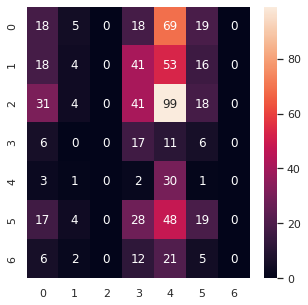

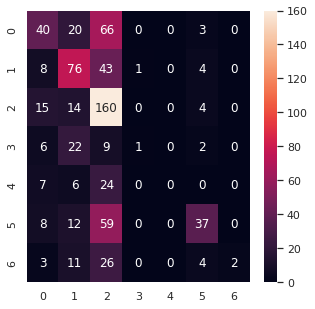

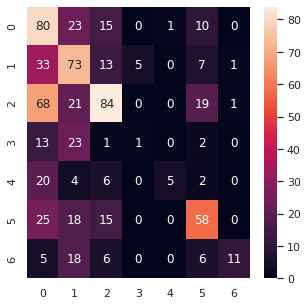

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(Y_test, y_pred, metric_nvpho, name_model_nvpho)
_confusion_matrix(Y_test, y_pred_nv, metric_nvtfidf, name_model_nvtfidf)
_confusion_matrix(Y_test, y_pred_svm, metric_svm, name_model_svm)